In [1]:
import random
import pandas as pd
import numpy as np
import pycuda.autoprimaryctx
from neural.basemodel import Model
from neural.network import Network
from neural.network.operator import Operator, Repeat, Add
from pycuda.elementwise import ElementwiseKernel
import pycuda.gpuarray as garray
import matplotlib.pyplot as plt

import skcuda
import skcuda.misc
skcuda.misc.init()
from tqdm.notebook import tqdm

In [8]:
class NoisyConnorStevens(Model):
    """
    Connor-Stevens Model
    """

    Time_Scale = 1e3  # s to ms
    Default_States = dict(
        v=(-60, -80, 80),
        n=(0.0, 0.0, 1.0),
        m=(0.0, 0.0, 1.0),
        h=(1.0, 0.0, 1.0),
        a=(1.0, 0.0, 1.0),
        b=(1.0, 0.0, 1.0),
        spike=0,
        v1=-60.0,
        v2=-60.0,
        refactory=0.0,
    )
    Default_Params = dict(
        ms=-5.3,
        ns=-4.3,
        hs=-12.0,
        gNa=120.0,
        gK=20.0,
        gL=0.3,
        ga=47.7,
        ENa=55.0,
        EK=-72.0,
        EL=-17.0,
        Ea=-75.0,
        sigma=2.05,
        refperiod=1.5,
    )

    def ode(self, stimulus=0.0):

        alpha = np.exp(-(self.v + 50.0 + self.ns) / 10.0) - 1.0
        if abs(alpha) <= 1e-7:
            alpha = 0.1
        else:
            alpha = -0.01 * (self.v + 50.0 + self.ns) / alpha
        beta = 0.125 * np.exp(-(self.v + 60.0 + self.ns) / 80.0)
        n_inf = alpha / (alpha + beta)
        tau_n = 2.0 / (3.8 * (alpha + beta))

        alpha = np.exp(-(self.v + 35.0 + self.ms) / 10.0) - 1.0
        if abs(alpha) <= 1e-7:
            alpha = 1.0
        else:
            alpha = -0.1 * (self.v + 35.0 + self.ms) / alpha
        beta = 4.0 * np.exp(-(self.v + 60.0 + self.ms) / 18.0)
        m_inf = alpha / (alpha + beta)
        tau_m = 1.0 / (3.8 * (alpha + beta))

        alpha = 0.07 * np.exp(-(self.v + 60.0 + self.hs) / 20.0)
        beta = 1.0 / (1.0 + np.exp(-(self.v + 30.0 + self.hs) / 10.0))
        h_inf = alpha / (alpha + beta)
        tau_h = 1.0 / (3.8 * (alpha + beta))

        a_inf = np.cbrt(0.0761 * np.exp((self.v + 94.22) / 31.84) / (1.0 + np.exp((self.v + 1.17) / 28.93)))
        tau_a = 0.3632 + 1.158 / (1.0 + np.exp((self.v + 55.96) / 20.12))
        b_inf = np.power(1 / (1 + np.exp((self.v + 53.3) / 14.54)), 4.0)
        tau_b = 1.24 + 2.678 / (1 + np.exp((self.v + 50) / 16.027))

        i_na = self.gNa * np.power(self.m, 3) * self.h * (self.v - self.ENa)
        i_k = self.gK * np.power(self.n, 4) * (self.v - self.EK)
        i_l = self.gL * (self.v - self.EL)
        i_a = self.ga * np.power(self.a, 3) * self.b * (self.v - self.Ea)

        self.d_v = stimulus - i_na - i_k - i_l - i_a
        self.d_n = (n_inf - self.n) / tau_n + random.gauss(0.0, self.sigma)
        self.d_m = (m_inf - self.m) / tau_m + random.gauss(0.0, self.sigma)
        self.d_h = (h_inf - self.h) / tau_h + random.gauss(0.0, self.sigma)
        self.d_a = (a_inf - self.a) / tau_a + random.gauss(0.0, self.sigma)
        self.d_b = (b_inf - self.b) / tau_b + random.gauss(0.0, self.sigma)

        self.d_refactory = self.refactory < 0

    def post(self):
        self.spike = (self.v1 < self.v2) * (self.v < self.v2) * (self.v > -30.0)
        self.v1 = self.v2
        self.v2 = self.v
        self.spike = (self.spike > 0.0) * (self.refactory >= 0)
        self.refactory -= (self.spike > 0.0) * self.refperiod

## Find Resting Spike Rate

In [14]:
dt = 1e-5
dur = 5
sigma = np.linspace(0, 0.003, 100)
N = 50
csn = NoisyConnorStevens(sigma=np.repeat(sigma, N)/np.sqrt(dt))
csn.compile(backend='cuda')x

spikes = np.zeros(len(sigma)*N)
I_g = garray.to_gpu(np.zeros_like(spikes))
for _t in tqdm(np.arange(0, dur, dt)):
    csn.update(dt, stimulus=I_g)
    if _t >= .5:
        spikes += csn.spike.get()

  0%|          | 0/500000 [00:00<?, ?it/s]

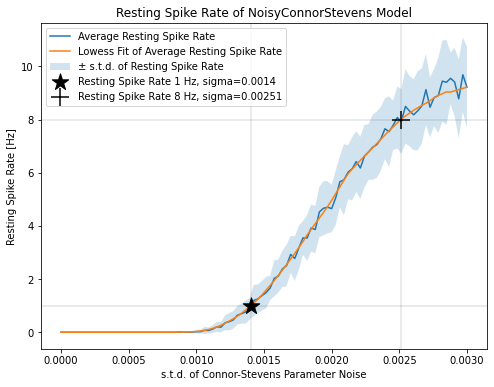

In [75]:
import statsmodels.api as sm

resting_spikerate = spikes.reshape((len(sigma), N))/(dur-.5)
resting_spikerate_avg = resting_spikerate.mean(-1)
resting_spikerate_std = resting_spikerate.std(-1)
resting_spikerate_interp_x, resting_spikerate_interp_y = sm.nonparametric.lowess(resting_spikerate_avg, sigma, frac=0.1).T

fig,ax = plt.subplots(1,1, figsize=(8,6))
_ = ax.plot(sigma, resting_spikerate_avg, label='Average Resting Spike Rate')
_ = ax.plot(resting_spikerate_interp_x, resting_spikerate_interp_y, label='Lowess Fit of Average Resting Spike Rate')

sigma_resting_1 = np.interp(1, resting_spikerate_interp_y, resting_spikerate_interp_x)
sigma_resting_8 = np.interp(8, resting_spikerate_interp_y, resting_spikerate_interp_x)

_ = ax.fill_between(
    sigma, 
    resting_spikerate_avg-resting_spikerate_std, 
    resting_spikerate_avg+resting_spikerate_std, 
    alpha=.2,
    label='± s.t.d. of Resting Spike Rate'
)
ax.scatter(sigma_resting_1, 1, s=300, c='k', marker='*', label=f'Resting Spike Rate 1 Hz, sigma={sigma_resting_1:.3g}', zorder=100)
ax.scatter(sigma_resting_8, 8, s=300, c='k', marker='+', label=f'Resting Spike Rate 8 Hz, sigma={sigma_resting_8:.3g}', zorder=100)
ax.axvline(sigma_resting_1, c='k', alpha=.1)
ax.axvline(sigma_resting_8, c='k', alpha=.1)
ax.axhline(1, c='k', alpha=.1)
ax.axhline(8, c='k', alpha=.1)
           
ax.set(xlabel='s.t.d. of Connor-Stevens Parameter Noise', ylabel='Resting Spike Rate [Hz]', title='Resting Spike Rate of NoisyConnorStevens Model')
ax.legend()

## Find Limit Cycle Mountains